## 1. Introducción

**Integrantes:**


1.   Angelo Antunez
2.   Juan Collantes
3.   Ronal Noa



**Sinopsis**

El caso se centra en Compass Maritime Services (CMS), una empresa de corretaje marítimo especializada en la compra, venta y valorización de barcos. En mayo de 2008, Basil Karatzas, director de finanzas y proyectos, enfrenta el desafío de determinar un precio razonable para el barco “Bet Performer”, un carguero tipo capesize que un cliente desea adquirir. En un mercado marítimo volátil y competitivo, Karatzas debe emplear métodos de valorización basados en datos históricos y características del barco, además de diseñar una estrategia de negociación efectiva. El éxito de esta operación depende de ofrecer un precio competitivo sin comprometer la relación con el cliente ni la reputación de CMS como un actor clave en la industria.

**Problema**

Determinar un precio razonable para el barco “Bet Performer” que permita al cliente de Compass Maritime Services realizar una oferta competitiva sin comprometer la viabilidad de la operación en un mercado marítimo volátil y altamente competitivo.

**Información de datos**

- Sale.Date: Fecha de venta
- Vessel.Name: Nombre del barco
- Sale.Price: Precio de venta
- year.Built: Año en que el barco fue construido
- Age.at.Sale (Year of Sale − Year Built): Antigüedad del barco en el momento de su compra.
- Dead.Weight.Tons: Peso muerto
- Avg.Month.Balt: Promedio móvil de 1 año de los valores mensuales del índice Baltic Dry (BDI).

## 2. Lectura y arreglo de datos

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import datetime
from datetime import date
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Colab Juan Jose/otros/pebiba')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
Ad_df = pd.read_excel('211702-XLS-ENG.xlsx',sheet_name='base')
Ad_df.drop(columns = 'Unnamed: 0', inplace=True)
Ad_df['Sale Date']=pd.to_datetime(Ad_df['Sale Date'],format='%Y-%m-%d')
Ad_df.columns=["Sale.Date", "Vessel.Name", "Sale.Price", "year.Built","Age.at.Sale", "Dead.Weight.Tons","Avg.Month.Balt"]
Ad_df['Flag.fecha'] = Ad_df['Sale.Date'].apply(lambda x: 0 if int(x.strftime('%Y%m')) <= 200706 else 1) #Dummy de fecha
Ad_df['Flag.fecha'] = Ad_df['Flag.fecha'].astype('category')
Ad_df['Age.at.Sale_Flag.fecha'] = Ad_df['Age.at.Sale'] * Ad_df['Flag.fecha'].astype(float)

In [3]:
Ad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Sale.Date               48 non-null     datetime64[ns]
 1   Vessel.Name             48 non-null     object        
 2   Sale.Price              48 non-null     float64       
 3   year.Built              48 non-null     int64         
 4   Age.at.Sale             48 non-null     int64         
 5   Dead.Weight.Tons        48 non-null     float64       
 6   Avg.Month.Balt          48 non-null     float64       
 7   Flag.fecha              48 non-null     category      
 8   Age.at.Sale_Flag.fecha  48 non-null     float64       
dtypes: category(1), datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 3.3+ KB


**Observaciones:** La mayoría de las variables con las que cuenta el dataframe son numéricas, de tipo entero y decimal, solo la dummy de fecha es del tipo categoría.

## 3. Regresion Lineal Múltiple

#### 3.1. Introducción al modelo

In [4]:
mlr_model = linear_model.LinearRegression()
mlr_model.fit(Ad_df[['Age.at.Sale', 'Dead.Weight.Tons', 'Avg.Month.Balt','Flag.fecha','Age.at.Sale_Flag.fecha']], Ad_df['Sale.Price']) #Acá se eligieron las variables del modelo que finalmente quedó como el mejor en el laboratorio correspondiente

LinearRegression()

In [5]:
Ad_df['Sale.Price_Predicted']  = mlr_model.predict(Ad_df[['Age.at.Sale', 'Dead.Weight.Tons', 'Avg.Month.Balt','Flag.fecha','Age.at.Sale_Flag.fecha']])
Ad_df['Error'] = (Ad_df['Sale.Price_Predicted'] - Ad_df['Sale.Price'])**2
MSE_MLR = Ad_df['Error'].mean()

In [6]:
R2=mlr_model.score(Ad_df[['Age.at.Sale', 'Dead.Weight.Tons', 'Avg.Month.Balt','Flag.fecha','Age.at.Sale_Flag.fecha']], Ad_df['Sale.Price'])

In [7]:
print(f"El Error Cuadrático Medio (MSE) del modelo de regresión lineal es: {MSE_MLR}")
print(f"El coeficiente de determinación R^2 del modelo de regresión lineal es: {R2}")

El Error Cuadrático Medio (MSE) del modelo de regresión lineal es: 54.26418624908533
El coeficiente de determinación R^2 del modelo de regresión lineal es: 0.951763486758436


**Observaciones:** El modelo OLS sin splitear datos en train/test muestra un coeficiente de determinación alto: 95%. Recordemos que este era el modelo catalogado como el mejor de los 5 revisados en clase. El MSE es 54.2, lo que quiere decir que las predicciones del modelo estiman/sobrestiman el precio real con esa diferencia aproximadamente.

#### 3.2. Modelo en detalle

In [8]:
Ad_df_2=Ad_df.rename(columns={
    'Age.at.Sale': 'Age_at_Sale',
    'Dead.Weight.Tons': 'Dead_Weight_Tons',
    'Avg.Month.Balt': 'Avg_Month_Balt',
    'Flag.fecha': 'Flag_fecha',
    'Age.at.Sale_Flag.fecha': 'Age_at_Sale_Flag_fecha',
    'Sale.Price':'Sale_Price'
})

In [9]:
import statsmodels.formula.api as smf
lm1 = smf.ols(formula='Sale_Price ~ Age_at_Sale + Dead_Weight_Tons + Avg_Month_Balt + Flag_fecha + Age_at_Sale_Flag_fecha', data=Ad_df_2).fit()
lm1.params
print(lm1.summary())  #Inferential statistics

                            OLS Regression Results                            
Dep. Variable:             Sale_Price   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     165.7
Date:                Sat, 21 Dec 2024   Prob (F-statistic):           1.65e-26
Time:                        18:25:46   Log-Likelihood:                -163.96
No. Observations:                  48   AIC:                             339.9
Df Residuals:                      42   BIC:                             351.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 40

In [10]:
print("*************Parameters**************")
print(lm1.params)
print("*************P-Values**************")
print(lm1.pvalues)
print("************Standard Errors***************")
print(lm1.bse)
print("*************Confidence Interval**************")
print(lm1.conf_int())
print("*************Error Covariance Matrix**************")
print(lm1.cov_params())

*************Parameters**************
Intercept                 40.133748
Flag_fecha[T.1]           40.358234
Age_at_Sale               -3.404078
Dead_Weight_Tons           0.272237
Avg_Month_Balt             0.004147
Age_at_Sale_Flag_fecha    -1.726679
dtype: float64
*************P-Values**************
Intercept                 8.171974e-03
Flag_fecha[T.1]           5.339060e-06
Age_at_Sale               5.439860e-12
Dead_Weight_Tons          5.966289e-04
Avg_Month_Balt            1.646078e-04
Age_at_Sale_Flag_fecha    1.305537e-04
dtype: float64
************Standard Errors***************
Intercept                 14.454446
Flag_fecha[T.1]            7.743667
Age_at_Sale                0.359193
Dead_Weight_Tons           0.073313
Avg_Month_Balt             0.001002
Age_at_Sale_Flag_fecha     0.409858
dtype: float64
*************Confidence Interval**************
                                0          1
Intercept               10.963494  69.304001
Flag_fecha[T.1]         24.730882  

In [11]:
lm1.cov_params()

,Intercept,Flag_fecha[T.1],Age_at_Sale,Dead_Weight_Tons,Avg_Month_Balt,Age_at_Sale_Flag_fecha
Intercept,208.931015,-2.904185,-2.883192,-0.928776,-0.004101,1.749170
Flag_fecha[T.1],-2.904185,59.964377,1.586451,0.042804,-0.004864,-2.430554
Age_at_Sale,-2.883192,1.586451,0.129020,0.008768,-0.000025,-0.119354
Dead_Weight_Tons,-0.928776,0.042804,0.008768,0.005375,-0.000007,-0.002696
Avg_Month_Balt,-0.004101,-0.004864,-0.000025,-0.000007,0.000001,0.000034
Age_at_Sale_Flag_fecha,1.749170,-2.430554,-0.119354,-0.002696,0.000034,0.167983


**Observaciones:** Por lo general no se observan altas varianzas salvo en el intercepto y en la dummy de fecha. Además de eso, las covarianzas pequeñas entre variables indican que es probable que no existan problemas de correlación entre variables

#### 3.3. Visualización de banda de confianza

Age.at.Sale
Dead.Weight.Tons
Avg.Month.Balt
Age.at.Sale_Flag.fecha


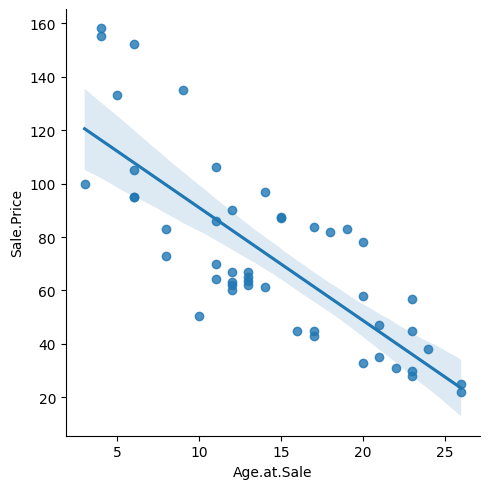

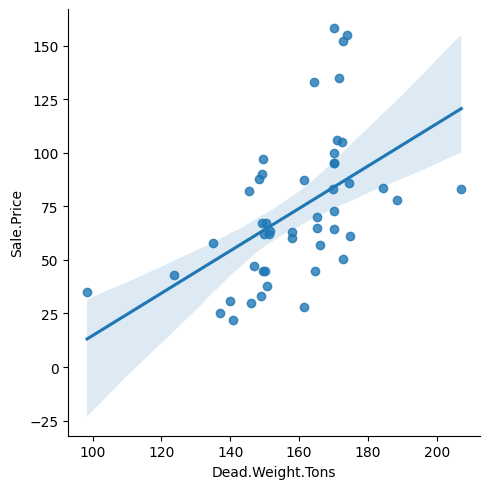

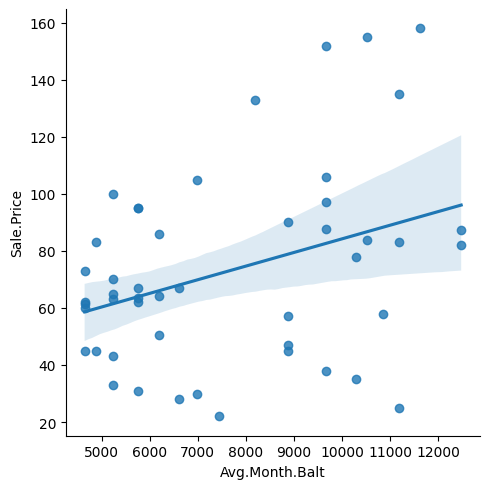

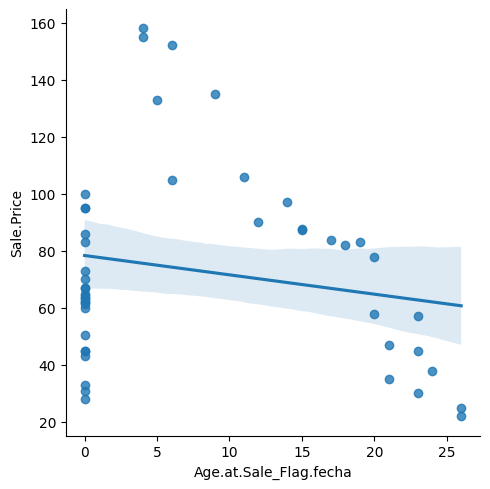

In [12]:
import seaborn as sns
for i in ['Age.at.Sale', 'Dead.Weight.Tons', 'Avg.Month.Balt','Age.at.Sale_Flag.fecha']: # Sin Flag.fecha porque es dummy
  print(i)
  sns.lmplot(x=i,y='Sale.Price',data=Ad_df)

**Observaciones:** Se observa que hay cierta asociación lineal de Sale.Price con Age.at.Sale (el precio baja cuando es más antiguo), con Dead.Weight.Tons (el precio aumenta cuando el barco es mas grande) y con Avg.Month.Balt (el precio aumenta cuando el índice báltico es más alto)

In [13]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#### 3.4. Separación de datos

In [14]:
# División de los datos en train y test
# ==============================================================================
X = Ad_df[['Age.at.Sale', 'Dead.Weight.Tons', 'Avg.Month.Balt','Flag.fecha','Age.at.Sale_Flag.fecha']]
y = Ad_df['Sale.Price']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular el MSE y R^2 en el conjunto de prueba
rmse_ols = mean_squared_error(y_test, y_pred)
R2_test = r2_score(y_test, y_pred)

print(f"El Error Cuadrático Medio (MSE) en el conjunto de prueba es: {rmse_ols}")
print(f"El coeficiente de determinación R^2 en el conjunto de prueba es: {R2_test}")

El Error Cuadrático Medio (MSE) en el conjunto de prueba es: 53.10789890633855
El coeficiente de determinación R^2 en el conjunto de prueba es: 0.8912563818716593


In [17]:
# Asegúrate de que los coeficientes sean unidimensionales
coeficientes = pipeline.named_steps['model'].coef_.flatten()

# Crear el DataFrame con los coeficientes y los nombres de las columnas
df_coeficientes = pd.DataFrame(
    {
        'predictor': X_train.columns if hasattr(X_train, 'columns') else [f"Variable_{i+1}" for i in range(X_train.shape[1])],
        'coef': coeficientes
    }
)

In [18]:
df_coeficientes

,predictor,coef
0,Age.at.Sale,-21.451582
1,Dead.Weight.Tons,4.456903
2,Avg.Month.Balt,13.294581
3,Flag.fecha,17.409937
4,Age.at.Sale_Flag.fecha,-14.956731


**Observaciones:** Se obtiene un coeficiente de determinación alto (89%) para el conjunto de prueba y se obtiene un MSE mejorable. Por ello, se intentará disminuir ello con métodos de regularización.

## 4. Regularización

### 4.1. Regresión Ridge

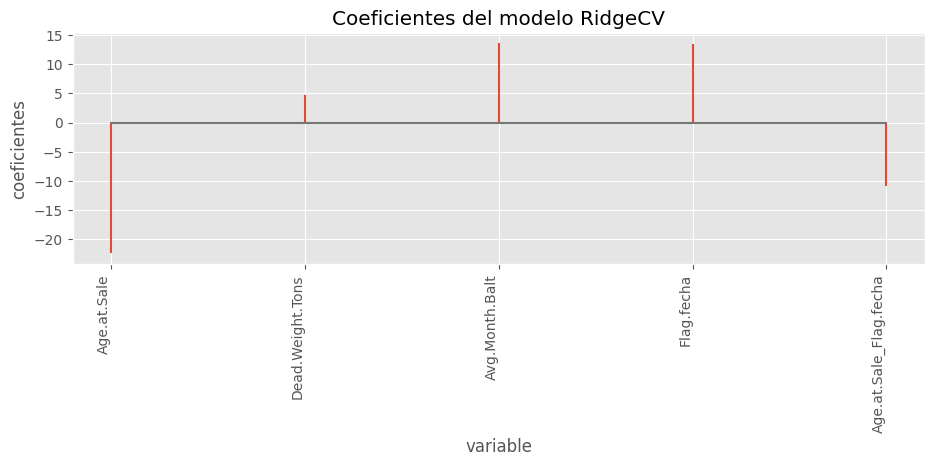

In [19]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
# Crear un pipeline que primero escale los datos y luego ajuste el modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RidgeCV(
        alphas=np.logspace(-10, 2, 200),
        fit_intercept=True,
        store_cv_values=True
    ))
])

pipeline.fit(X_train, y_train)
modelo = pipeline.named_steps['model']
df_coeficientes = pd.DataFrame(
    {'predictor': X_train.columns,
     'coef': modelo.coef_.flatten()}
)

fig, ax = plt.subplots(figsize=(11, 3))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo RidgeCV')
plt.show()

Cuando se utiliza regularización, es útil evaluar cómo se aproximan a cero los coeficientes a medida que se incrementa el valor de alpha así como la evolución del error de validación cruzada en función del alpha empleado.

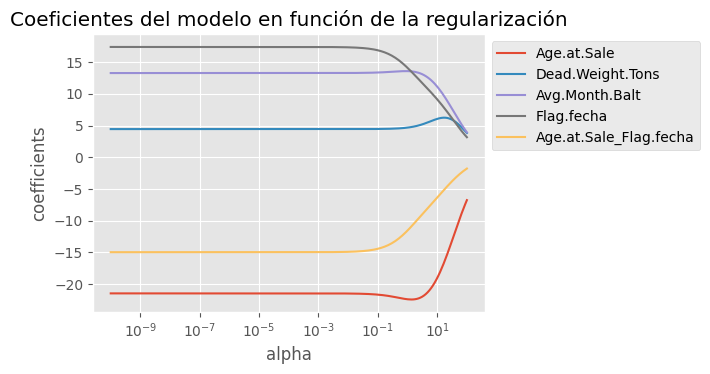

In [20]:
from sklearn.pipeline import Pipeline, make_pipeline
# Evolución de los coeficientes en función de alpha
# ==============================================================================
# Definir alphas para la regularización
alphas = np.logspace(-10, 2, 200)
coefs = []

# Asumimos que X_train tiene columnas que representan las variables originales
variable_names = X_train.columns  # O lista manual con nombres de variables

# Guardar coeficientes por cada alpha
coefs = []
for alpha in alphas:
    modelo_temp = make_pipeline(StandardScaler(), Ridge(alpha=alpha, fit_intercept=False))
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.named_steps['ridge'].coef_.flatten())

# Convertir la lista de coeficientes a un array para manejar variables
coefs = np.array(coefs).T  # Transponer para que cada fila sea una variable

# Modificar ubicación de la leyenda
fig, ax = plt.subplots(figsize=(7, 3.84))
for coef, name in zip(coefs, variable_names):
    ax.plot(alphas, coef, label=name)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coefficients')
ax.set_title('Coeficientes del modelo en función de la regularización')
ax.axis('tight')

# Mover la leyenda a la esquina superior izquierda fuera del área de dibujo
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Asegurar que todo se ajuste bien en la figura
plt.show()

Los coeficientes no se ven afectados por la regularización hasta alfa = 1/10. Esta situación puede ocurrir debido a que las variables del modelo tienen un impacto significativo y constante en la predicción, independientemente del nivel de regularización que se aplique. Es posible que estas variables sean fundamentales para explicar la relación entre las características y la variable objetivo, por lo que el modelo no encuentra necesario ajustar sus coeficientes, incluso cuando se introduce regularización.
- Decaimiento después de 10: A partir de un valor de alpha de aproximadamente 1/10,  algunos coeficientes empiezan a disminuir rápidamente (por ejemplo, la línea correspondiente a 'Age.at.Sale' en rojo y otras), indicando que la penalización de la regularización Ridge comienza a tener un impacto importante. Estas características empiezan a ser consideradas menos relevantes para el modelo bajo una regularización más estricta.
- Impactos contrarios en variables: Algunas líneas, como 'Age.at.Sale_Flag.fecha', muestran un cambio hacia un crecimiento positivo tras un decaimiento inicial. Esto puede reflejar que la interacción o combinación de características se ajusta a niveles altos del coeficiente, haciendo que el modelo revalorice su importancia relativa.

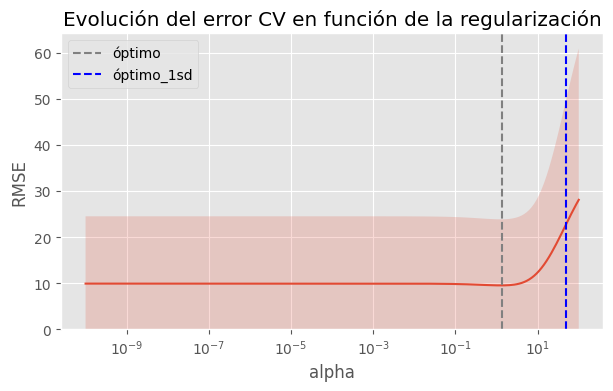

In [21]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = np.sqrt(mse_sd[np.argmin(rmse_cv)])  # Se calcula la raíz cuadrada del MSE_SD
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])

# Se obtiene el valor óptimo de alpha
optimo       = modelo.alphas[np.argmin(rmse_cv)]

# Se obtiene el valor de alpha que corresponde a min_rsme_1sd, si existe
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [22]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1.350993521198025


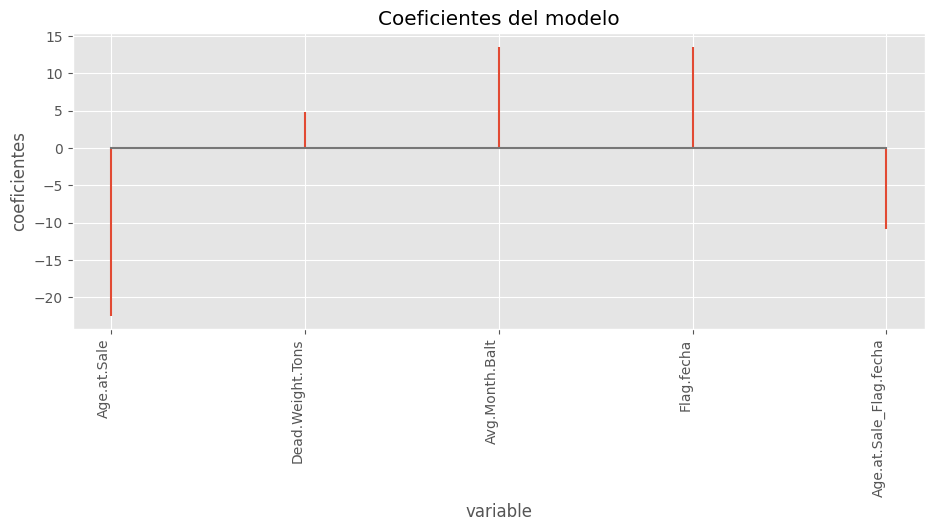

In [23]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [24]:
df_coeficientes

,predictor,coef
0,Age.at.Sale,-22.415933
1,Dead.Weight.Tons,4.783184
2,Avg.Month.Balt,13.563479
3,Flag.fecha,13.509232
4,Age.at.Sale_Flag.fecha,-10.890300


En comparación al modelo por mínimos cuadrados ordinarios, con ridge, el orden de magnitud de los coeficientes es parecido.

In [25]:
# Predicciones test utilizando el pipeline
# ==============================================================================
predicciones = pipeline.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 62.39538717, 103.81762423,  91.61829749,  63.25482076,
        50.72107348,  37.03390818,  58.06153945,  46.4845085 ,
        91.61829749,  25.98777822])

In [26]:
from sklearn.metrics import mean_squared_error

# Error de test del modelo RidgeCV
# ==============================================================================

rmse_ridge = np.sqrt(mean_squared_error(y_true=y_test, y_pred=predicciones))

print(f"El error (RMSE) de test es: {rmse_ridge}")

El error (RMSE) de test es: 7.508339856943451


**Conclusiones:**

### 4.2. Regresión Lasso

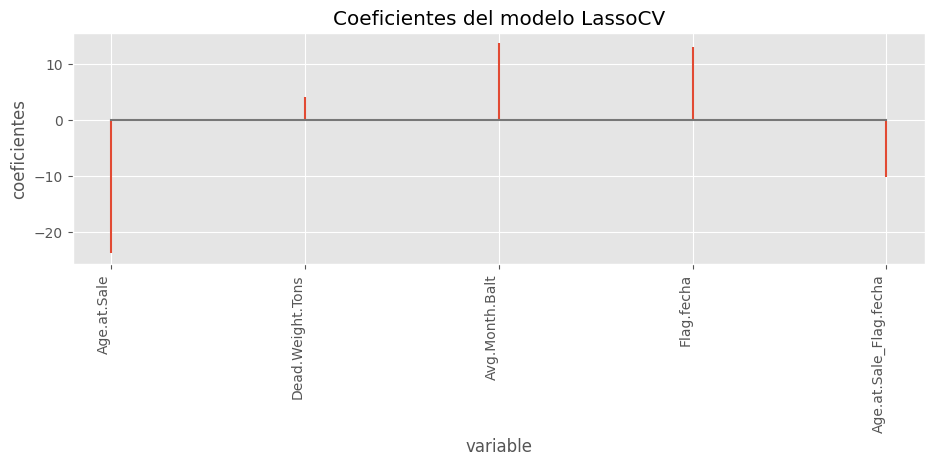

In [27]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Creación y entrenamiento del modelo con búsqueda por CV del valor óptimo alpha
# ==============================================================================
# Definir el pipeline que incluye el escalado y LassoCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LassoCV(alphas=np.logspace(-10, 3, 200), cv=10))
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Obtener el mejor modelo de LassoCV del pipeline
modelo = pipeline.named_steps['model']

# Coeficientes del modelo
df_coeficientes = pd.DataFrame({
    'predictor': X_train.columns,
    'coef': modelo.coef_
})

# Visualización de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(11, 3))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo LassoCV')
plt.show()

Cuando se utiliza regularización, es útil evaluar cómo se aproximan a cero los coeficientes a medida que se incrementa el valor de alpha así como la evolución del error de validación cruzada en función del alpha empleado.

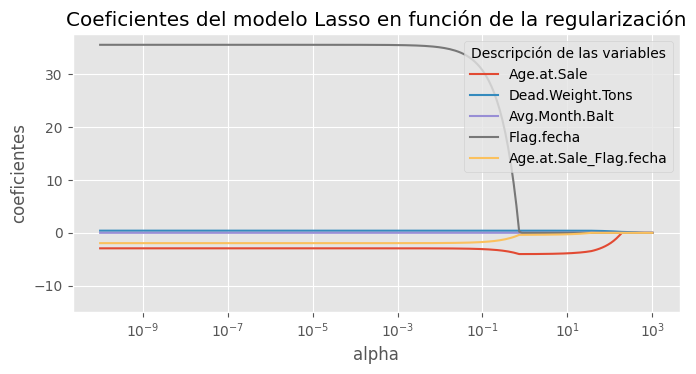

In [28]:
from sklearn.linear_model import LassoCV

# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Definir el modelo LassoCV para encontrar el mejor alpha automáticamente
modelo = LassoCV(alphas=np.logspace(-10, 3, 200), cv=10)

# Ajustar el modelo a los datos de entrenamiento
_ = modelo.fit(X_train, y_train)

# Obtener los alphas utilizados durante la búsqueda (opcional)
alphas = modelo.alphas_

# Nombres de las variables
variable_names = X_train.columns  # O lista manual con nombres de variables

# Evolución de los coeficientes en función de alpha
coefs = []
for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_)

# Visualización de la evolución de los coeficientes en función de alpha
fig, ax = plt.subplots(figsize=(7, 3.84))
for i, variable_name in enumerate(variable_names):
    ax.plot(alphas, np.array(coefs)[:, i], label=variable_name)

ax.set_xscale('log')
ax.set_ylim([-15, None])  # Ajusta el límite y según tus datos
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo Lasso en función de la regularización')
ax.legend(title='Descripción de las variables', loc='best')
plt.tight_layout()
plt.show()

**Observaciones:** La variable que más variaciones sufre en su beta estimado es Flag.fecha, esto debido a su poca variabilidad y a la restricción fuerte de la función de costo de la estimación Lasso. Asimismo, tal cual indica la teoría. A medida que el alpha aumenta, los coeficientes de las variables se acercan a cero por la restricción antes mencionada.

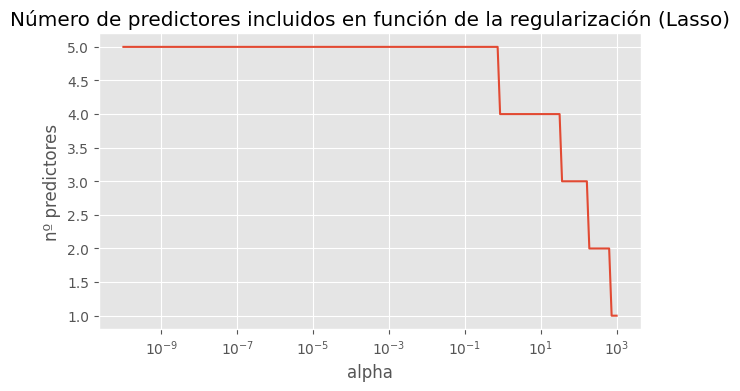

In [29]:
from sklearn.linear_model import LassoCV, Lasso

# Creación y entrenamiento del modelo LassoCV para búsqueda de alpha óptimo
modelo = LassoCV(alphas=np.logspace(-10, 3, 200), cv=10)

# Ajustar el modelo a los datos de entrenamiento
_ = modelo.fit(X_train, y_train)

# Obtener los alphas utilizados durante la búsqueda (opcional)
alphas = modelo.alphas_

# Número de predictores incluidos en función de alpha
n_predictores = []
for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_ != 0)
    n_predictores.append(coef_no_cero)

# Visualización del número de predictores incluidos en función de alpha
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Número de predictores incluidos en función de la regularización (Lasso)')
plt.show()

Dentro de ese rango de alphas, el modelo Lasso está manteniendo consistentemente 3 predictores en el modelo. Es probable que estos predictores sean considerados importantes o relevantes para el modelo, ya que sus coeficientes no se reducen a cero incluso con una regularización más fuerte. Pero después de 100 se reduce a solo 1 coeficiente.

Cuando el valor de alpha aumenta significativamente, el modelo Lasso aplica una regularización más fuerte. Esta penalización adicional puede hacer que el modelo reduzca drásticamente el número de predictores incluidos, llegando incluso a eliminar casi todos los predictores, dejando únicamente 1 predictor en el modelo.

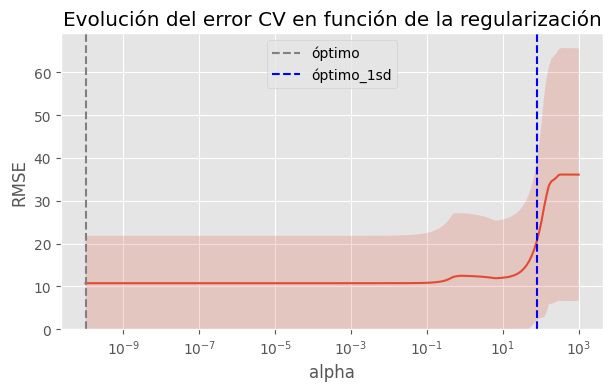

In [30]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [31]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Valor de alpha óptimo + 1SD: {optimo_1sd[0]}")

Mejor valor de alpha encontrado: 1e-10
Valor de alpha óptimo + 1SD: 77.52597488629465


In [32]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Creación y entrenamiento del modelo LassoCV
# ==============================================================================
modelo = LassoCV(
            alphas    = np.logspace(-10, 3, 200),
            cv        = 10
         )
_ = modelo.fit(X_train, y_train)

# Mejor valor alpha encontrado
optimo = modelo.alpha_

# Crear un pipeline que primero escale los datos y luego ajuste el modelo Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=optimo))
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train, y_train)

# Ejemplo de predicciones en el conjunto de prueba
predicciones = pipeline.predict(X_test)
predicciones[:10]

array([ 61.7971572 , 103.78207062,  89.79563611,  62.40366925,
        49.56273936,  34.30353406,  57.50551152,  44.36080414,
        89.79563611,  27.20111576])

Se entrena de nuevo el modelo, esta vez empleando el mayor valor de alpha cuyo error está a menos de una desviación típica del mínimo encontrado en la validación cruzada.

In [33]:
from sklearn.linear_model import Lasso
import numpy as np

# Asegúrate de que optimo_1sd sea un array de numpy
optimo_1sd = np.array(optimo_1sd) if isinstance(optimo_1sd, list) else np.array([optimo_1sd])

if optimo_1sd.size > 0:
    # Obtener el mejor valor de alpha encontrado + 1sd
    alpha_optimo_1sd = float(optimo_1sd[0])  # Convertir el primer elemento en float si es necesario

    # Crear y ajustar el modelo Lasso con el alpha óptimo + 1sd
    modelo_lasso = Lasso(alpha=alpha_optimo_1sd, fit_intercept=False)
    modelo_lasso.fit(X_train, y_train)

    # Aquí puedes realizar cualquier operación adicional con el modelo ajustado
    print("Modelo Lasso ajustado con éxito.")
else:
    print("No se encontraron valores en optimo_1sd. Revisa tu código o los resultados obtenidos.")

Modelo Lasso ajustado con éxito.


In [34]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
0,Age.at.Sale,-3.420895
1,Dead.Weight.Tons,0.259412
2,Avg.Month.Balt,0.005534
3,Flag.fecha,34.835872
4,Age.at.Sale_Flag.fecha,-1.670431


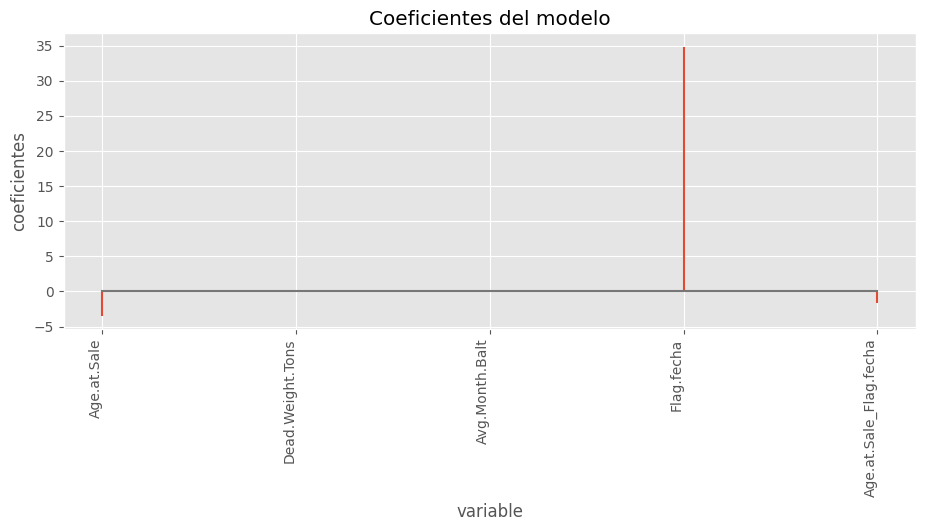

In [35]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [36]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 61.7971572 , 103.78207062,  89.79563611,  62.40366925,
        49.56273936,  34.30353406,  57.50551152,  44.36080414,
        89.79563611,  27.20111576])

In [37]:
# Error de test del modelo
# ==============================================================================

rmse_lasso = np.sqrt(mean_squared_error(y_true=y_test, y_pred=predicciones))

print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 7.287516649079657


**Observaciones:** Las predicciones del modelo final se alejan en promedio 7.28 unidades del valor real, utilizando los 5 predictores disponibles, pues el alpha optimo: 1e-10 conserva los 5.

## Comparación

Se compara el error de test (rmse) de los 4 modelos

In [38]:
import pandas as pd
import plotly.express as px

# Crear el DataFrame
df_comparacion = pd.DataFrame({
    'modelo': ['rmse_ols', 'Ridge', 'Lasso'],
    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso]
})

# Crear gráfico dinámico con Plotly
fig = px.bar(
    df_comparacion,
    x='test rmse',
    y='modelo',
    orientation='h',  # Barras horizontales
    title='Comparación de modelos',
    labels={'test rmse': 'RMSE', 'modelo': 'Modelo'},
    text='test rmse'  # Mostrar valores en las barras
)

# Mejorar diseño
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')  # Formato de valores
fig.update_layout(
    xaxis_title="RMSE",
    yaxis_title="Modelo",
    yaxis=dict(categoryorder='total ascending')  # Ordenar de menor a mayor
)

# Mostrar el gráfico
fig.show()

En este caso el mejor modelo se obtiene aplicando regularización Ridge o Lasso. El modelo con regularización Lasso tienen un error inferior al modelo OLS. Ya que todos los modelos quedan con los 5 predictores. Se elige el modelo Lasso. Sin embargo, al revisar los coeficientes estimados por los modelos se observa que:
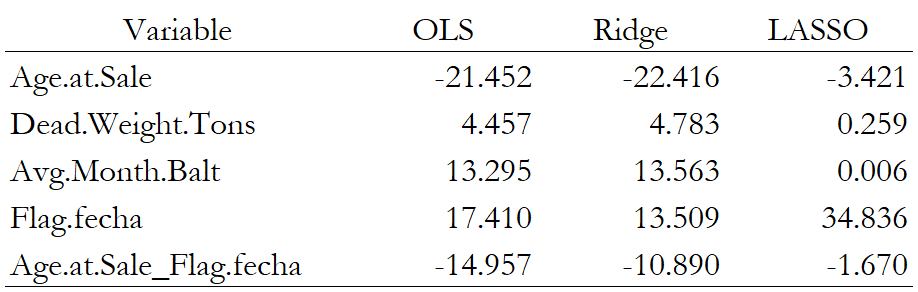
Lo que indica que la importancia de la dummy es considerablemente grande en comparación a los otros modelos. Lo cual representa un reto al explicar el modelo y también porque en la gerenación de nuevos datos esta siempre tomará el valor de uno, por lo que se opta por el modelo Ridge.